# Fixed point grover search


For the details of Grover's algorithm, please see [Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)

The fixed point search algorithm performs Grover like search without the possibility of overshooting i.e. we converge to the target state irrespective of the number of iterations.

Why is it important? <br>
It can lead to new schemes for quantum control.

**References:**

\[1\]: L. K. Grover, Fixed-Point Quantum Search. Physical Review Letters, 2005
https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.150501

\[2\]: Theodore J. Yoder, Guang Hao Low, Isaac L. Chuang, Fixed-Point Quantum Search with an Optimal Number of Queries. Physical Review Letters, 2014, https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.210501

## Phase shift


The grover oracle, when the winner state is $|w\rangle$, is given as
$$ U_{w}=I-2|w\rangle\langle w|. $$

Phase shift is a generalization of reflection (phase flip):

$$ U_{w}(\alpha)=I-(1-\exp(i\alpha))|w\rangle\langle w|.  $$

Similarly, the diffusion operator i.e. reflection $U_{s}$ about the equal superposition state $|s\rangle$ can be generalized to $$ U_{s}(\beta)=I-(1-\exp(i\beta))|s\rangle\langle s|.  $$

The fixed point Grover search algorithm uses $\alpha=\beta=\pi/3$

## Algorithm
Lets denote a Grover iteration as $G_{t}$ at step t.
In Grover search, after t steps, we have $$ G_{t}|s\rangle=(U_{s}U_{w})^{t}|s\rangle.$$

How many steps do we need to apply? If we have a list of N items, then roughly $\sqrt N$ times will suffice. If we iterate more, then we might overshoot the target state.

However, for the fixed point search, each iterate is related with last one by a recursion relation. 
$$ G_{t+1}=G_{t}U_{s}G^{\dagger}_{t}U_{w}G_{t}. $$
If we start from state $|0\rangle$, we can use $G_{0}=H$, where $H$ is the Hadamard gate. If we have an iteration count L such that $G_{L}|0\rangle$ takes us very close to the target state, then we will move closer to the target state for every $t>L$. This is how the fixed point algorithim reaches the target state. 
<br>

Can we also converge to the target state using the fixed point search while maintaining the quadratic speedup over classical? 
The answer is subtle and readers might enjoy going through the references mentioned in the beginning of the notebook.

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector

# import basic plot tools
from qiskit.visualization import plot_histogram

Before diving into the algorithm, it is worthwhile to revisit the issue of overshooting in the original Grover search algorithm.  

We repeat the example from qiskit textbook where the target state is $|11\rangle$. But instead of stopping after one iteration, if we keep on applying the Grover operator (Oracle and Diffusion), we can demonstrate the overshooting.



In [174]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [175]:
n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [176]:
def grover_iteration_U2(grover_circuit):
        grover_circuit.cz(0,1) # Oracle
        grover_circuit.draw()

        #(U_s)
        grover_circuit.h([0,1]) 
        grover_circuit.z([0,1])
        grover_circuit.cz(0,1)
        grover_circuit.h([0,1])


def Complete_circuit(n=2, N_iter=1):
    grover_circuit = QuantumCircuit(n)
    grover_circuit = initialize_s(grover_circuit, [0,1])
    #grover_circuit.draw()
    N_iterations=N_iter
    for i in range(N_iterations):
        
        grover_iteration_U2(grover_circuit)
        
    
    return grover_circuit


If we rotate only once, we should get the target state. 
This is verified by calculating the quantum state fidelity of the output state with the target state.

In [177]:
grover_circuit=Complete_circuit(n=2, N_iter=1)

In [178]:
from qiskit.quantum_info import state_fidelity

backend = Aer.get_backend('statevector_simulator')
job = execute(grover_circuit, backend)
qc_state = job.result().get_statevector(grover_circuit)


target_vector = np.array([0.0, 0.0, 0.0, 1.0])


state_fidelity(target_vector,qc_state)

1.0

We get a fidelity $(=1)$ as expected. However, we see periodicity in the fidelity if we continue to iterate as a consequence of the overshooting.

In [179]:
N_it_max=10

In [180]:


backend = Aer.get_backend('statevector_simulator')

target_vector = np.array([0.0, 0.0, 0.0, 1.0])

fidelity=[]

state_vecs=[]

for i in range(1, N_it_max):
    grover_circuit=Complete_circuit(n=2, N_iter=i)
    job = execute(grover_circuit, backend)
    qc_state = job.result().get_statevector(grover_circuit)

    #state_fidelity(target_vector,qc_state)
    state_vecs.append(qc_state)
    
    fidelity.append( state_fidelity(target_vector,qc_state) )
    


We then plot the fidelity against the number of iterations

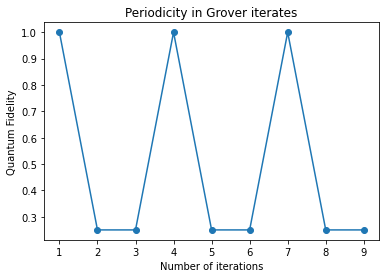

In [181]:
import matplotlib.pyplot as plt
x=range(1,N_it_max)

plt.plot(x, fidelity)

plt.xlabel("Number of iterations")

plt.ylabel("Quantum Fidelity")

plt.title("Periodicity in Grover iterates")

plt.scatter(x, fidelity)
plt.savefig("per_gro_it")
plt.show()

# Fixed point Search

In [182]:
from qiskit.quantum_info.operators import Operator, Pauli


We construct the phase shifted operators (oracle and diffusion) in a similar way to that of the non-fixed point Grover search algorithm. 

In [189]:
theta=np.pi/3

#Oracle
Ora = Operator([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.exp(1j*theta)]])

## Both these operators work since they differ by a global phase
#Rs = Operator([[np.exp(1j*theta), 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
Rs= Operator([[1, 0, 0, 0], [0, np.exp(-1j*theta), 0, 0], [0, 0, np.exp(-1j*theta), 0], [0, 0, 0, np.exp(-1j*theta)  ]])



We can either directly applying the oracles or transpile the unitary circuit into single qubit gates here. In general into 1 and 2 qubit gates
          
We chose to use the operator directly as it is more informative for this example with 2 qubits.

In [184]:
                        
def fixed_point_grover(N_iter):


    if N_iter==1:

        fixed_grover_circuit = QuantumCircuit(n)
        fixed_grover_circuit = initialize_s(fixed_grover_circuit, [0,1])

        #print( fixed_grover_circuit.draw() )

        ## 1st iteration    
        fixed_grover_circuit.append(Ora,[0,1])
        fixed_grover_circuit.draw()
        
        #(U_s)
        fixed_grover_circuit.h([0,1]) 
        fixed_grover_circuit.append(Rs,[0,1])
        fixed_grover_circuit.h([0,1])
    
        return fixed_grover_circuit
    
    else:
         
        fixed_grover_circuit = QuantumCircuit(n)
        
        op=Operator(fixed_point_grover(N_iter-1))
                
        #Adjoint of the opeartor
        adop=op.adjoint()
        
        
        fixed_grover_circuit.append(op,[0,1])
        #print(fixed_grover_circuit.draw())
        
        fixed_grover_circuit.append(Ora,[0,1])
 
        fixed_grover_circuit.append(adop,[0,1])

        #(U_s)
        #fixed_grover_circuit.h([0,1]) 
        fixed_grover_circuit.append(Rs,[0,1])
        #fixed_grover_circuit.h([0,1])
        
        fixed_grover_circuit.append(op,[0,1])
        
        
        return fixed_grover_circuit

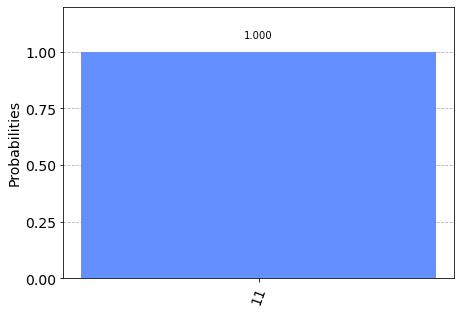

In [185]:

N_it_max=10

fixedgrover=fixed_point_grover(N_it_max)

fixedgrover.measure_all()

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024

results = execute(fixedgrover, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [186]:
from qiskit.quantum_info import state_fidelity

backend = Aer.get_backend('statevector_simulator')

target_vector = np.array([0.0, 0.0, 0.0, 1.0])

fidelity=[]

state_vecs=[]

for i in range(1, N_it_max):
    #grover_circuit=Complete_circuit(n=2, N_iter=i)
    #job = execute(grover_circuit, backend)
    fixedgrover=fixed_point_grover(i)
    job = execute(fixedgrover, backend)
    qc_state = job.result().get_statevector(fixedgrover)

    #state_fidelity(target_vector,qc_state)
    state_vecs.append(qc_state)
    
    fidelity.append( state_fidelity(target_vector,qc_state) )

Replotting the fidelity against iterations. Now, we have used fixed point search algorithm. Thus the fidelity saturates idicating we always converge towards the target state.

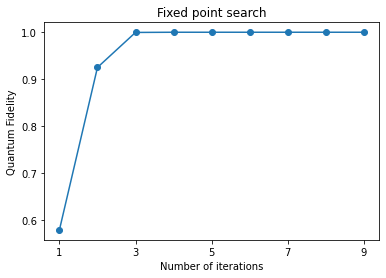

In [187]:
import matplotlib.pyplot as plt


x=range(1,N_it_max)
plt.xticks(range(1,N_it_max,2))

plt.ylabel("Quantum Fidelity")
plt.xlabel("Number of iterations")

plt.title("Fixed point search")

plt.plot(x, fidelity)
plt.scatter(x, fidelity)
plt.show()

It is important to note that there is an increase in the number of gates needed for each iterations unlike the Grover search algorithm. Some of the issues were alleviated in the paper "Fixed-Point Quantum Search with an Optimal Number of Queries" by Chuang et al. [2]

The advantage over classical algorithms can be better understood with an example. An unknown fraction $f=\frac{M}{N}$, of the states are marked. If $f$ is uniformly distributed between $1-\epsilon$ and $1$ where $\epsilon \in (0,\epsilon_{0})$. 
Also, $||G_{0,ts}||^{2}=1-\epsilon=f$. 
Classically, the very first guess will fail with probability $1-f$. Both first and second guess will fail w.p. $(1-f)^2$. Since f is unknown, the overall failure probability can be computed to be $\frac{\epsilon_{0}^{2}}{3}$

The very first iteration (0th order i.e. $G_{0,ts}$ ) yields the equal superposition state. However, one application of the fixed point Grover iteration gives us $||G_{1,ts}||^{2}=1-\epsilon^{3}$. Thus the overall failure probability becomes $\frac{\epsilon_{0}^3}{3}$ which is smaller than the classical counterpart, see [1].

In [188]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright